In [13]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib


In [5]:
# Load datasets
customers = pd.read_csv(r"D:\eleveta\Project 1\dataset\olist_customers_dataset.csv")
orders = pd.read_csv(r"D:\eleveta\Project 1\dataset\olist_orders_dataset.csv")
items = pd.read_csv(r"D:\eleveta\Project 1\dataset\olist_order_items_dataset.csv")
payments = pd.read_csv(r"D:\eleveta\Project 1\dataset\olist_order_payments_dataset.csv")

# Merge datasets
df = (orders
      .merge(customers, on='customer_id')
      .merge(items, on='order_id')
      .merge(payments, on='order_id'))

# Convert date
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['total_price'] = df['price'] + df['freight_value']


In [6]:
snapshot = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot - x.max()).days,
    'order_id': 'nunique',
    'total_price': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']
rfm['LTV'] = rfm['Monetary']


In [7]:
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['LTV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [9]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 6.07
RMSE: 126.51


In [10]:
rfm['Predicted_LTV'] = model.predict(X)
rfm['LTV_Segment'] = pd.qcut(rfm['Predicted_LTV'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


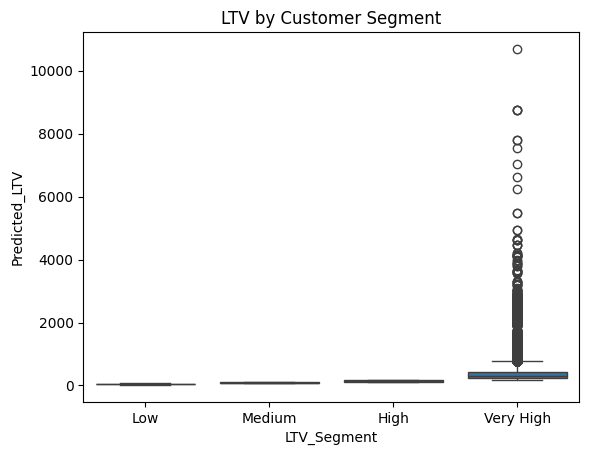

In [11]:
sns.boxplot(x='LTV_Segment', y='Predicted_LTV', data=rfm)
plt.title('LTV by Customer Segment')
plt.show()


In [12]:
rfm[['customer_id', 'Predicted_LTV', 'LTV_Segment']].to_csv('final_ltv_predictions.csv', index=False)
joblib.dump(model, 'ltv_model_xgboost.pkl')


['ltv_model_xgboost.pkl']

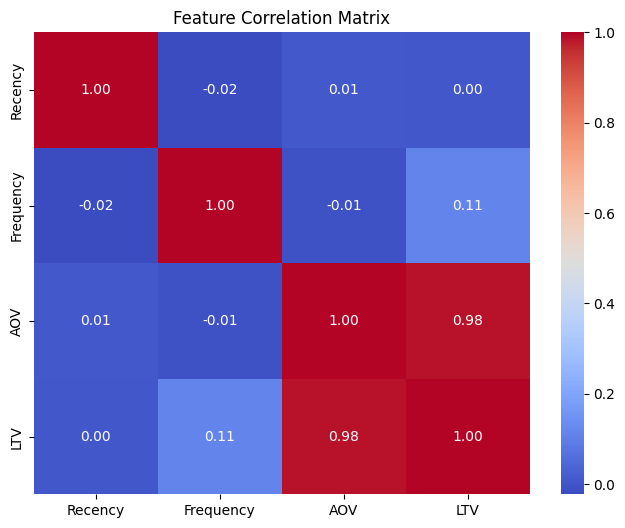

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(rfm[['Recency', 'Frequency', 'AOV', 'LTV']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

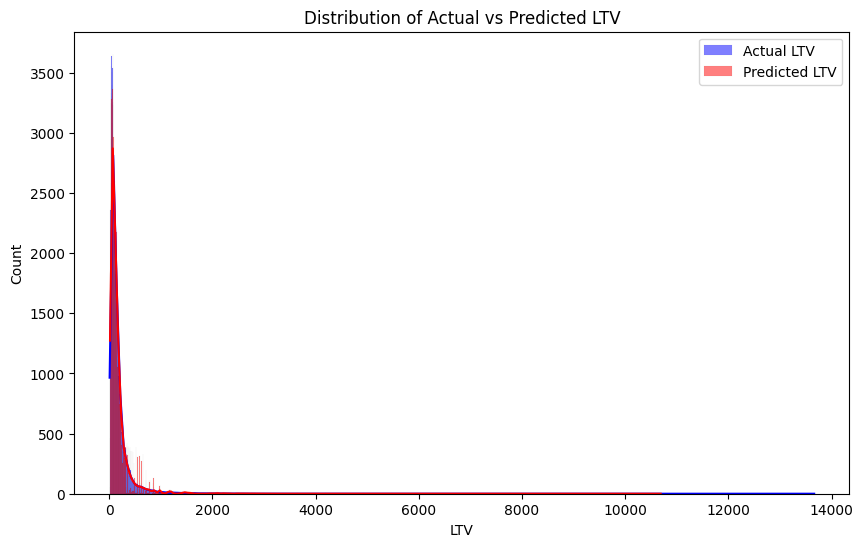

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm['LTV'], color='blue', label='Actual LTV', kde=True)
sns.histplot(rfm['Predicted_LTV'], color='red', label='Predicted LTV', kde=True)
plt.legend()
plt.title('Distribution of Actual vs Predicted LTV')
plt.show()

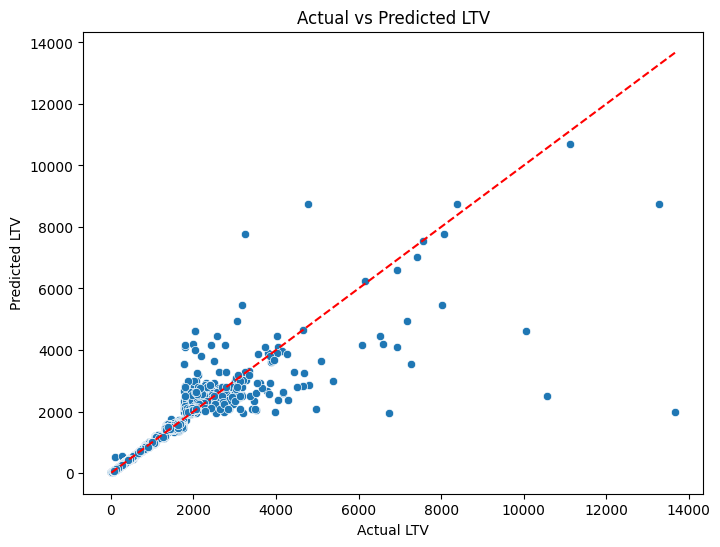

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm['LTV'], y=rfm['Predicted_LTV'])
plt.xlabel('Actual LTV')
plt.ylabel('Predicted LTV')
plt.title('Actual vs Predicted LTV')
plt.plot([rfm['LTV'].min(), rfm['LTV'].max()],
         [rfm['LTV'].min(), rfm['LTV'].max()],
         color='red', linestyle='--')  # identity line
plt.show()

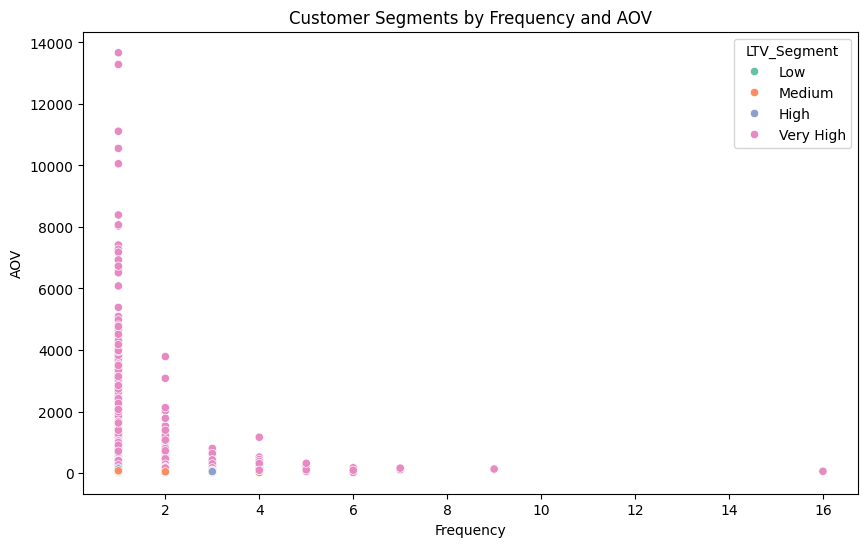

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='AOV', hue='LTV_Segment', palette='Set2')
plt.title('Customer Segments by Frequency and AOV')
plt.show()

<Axes: xlabel='LTV_Segment'>

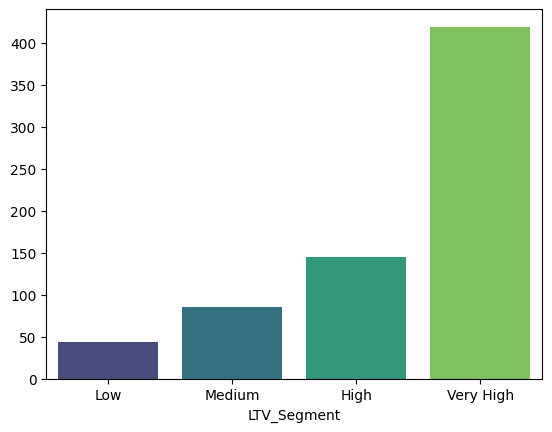

In [31]:
avg_ltv_segment = rfm.groupby('LTV_Segment', observed=True)['Predicted_LTV'].mean().sort_values()
sns.barplot(x=avg_ltv_segment.index, y=avg_ltv_segment.values, hue=avg_ltv_segment.index, palette='viridis', legend=False)


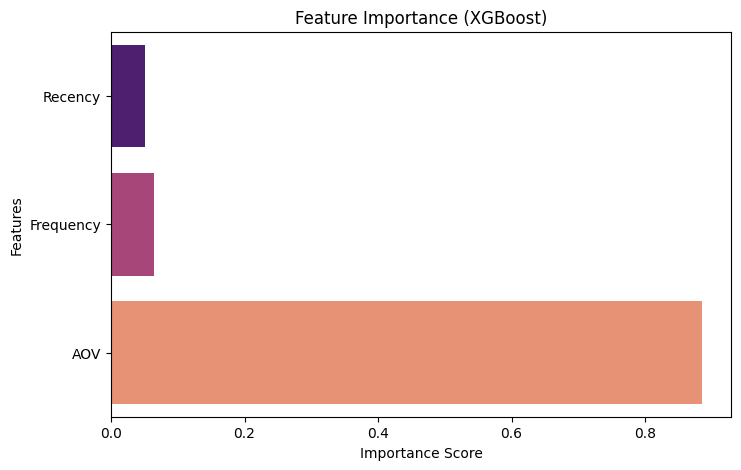

In [35]:
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, hue=features, palette='magma', legend=False)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
